<a href="https://colab.research.google.com/github/RH00000/UH_RTS_Research_ML/blob/main/simulation_gridsearch_same_confidence_with_3_ways_of_skip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Upload the profiling NPZ file from local machine (Colab)
from google.colab import files
uploaded = files.upload()

Saving abcd_profiling_validation_stats.npz to abcd_profiling_validation_stats.npz


In [3]:
# 1: Load profiling data
import numpy as np
import pandas as pd

data = np.load('abcd_profiling_validation_stats.npz')  # uses the uploaded file
confs = data['confs']    # shape (N,4)
times = data['times']    # shape (N,4)
oks   = data['oks']      # shape (N,4), bool
N, M = confs.shape       # N samples, M=4 models (A,B,C,D)

In [4]:
def simulate_cascade(confs, times, oks,
                     thr_a, thr_b, thr_c,
                     skip_b_thresh, skip_c_thresh):
    total_time     = 0.0
    correct        = 0
    skip_c_count   = 0
    skip_bc_count  = 0
    skip_b_to_c_count    = 0

    for j in range(N):
        # run A
        conf_a = confs[j,0]; t_a = times[j,0]; ok_a = oks[j,0]
        if conf_a >= thr_a:
            total_time += t_a
            correct    += ok_a
            continue

        # skip B?
        skip_b = (conf_a < skip_b_thresh)
        if not skip_b:
            # run B
            total_time += times[j,1]
            conf_b     = confs[j,1]
            ok_b       = oks[j,1]
            if conf_b >= thr_b:
                correct += ok_b
                continue
        else:
            conf_b = None

        # Decide skip C using conf_a if B skipped, else conf_b
        if skip_b:
            metric_for_c = conf_a
        else:
            metric_for_c = conf_b
        skip_c = (metric_for_c < skip_c_thresh)

        # increment appropriate counters
        if skip_b and not skip_c:
            skip_b_to_c_count += 1
        if skip_c and not skip_b:
            skip_c_count += 1
        if skip_b and skip_c:
            skip_bc_count += 1

        if not skip_c:
            # run C
            total_time += times[j,2]
            conf_c     = confs[j,2]
            ok_c       = oks[j,2]
            if conf_c >= thr_c:
                correct += ok_c
                continue

        # fallback D
        total_time += times[j,3]
        correct    += oks[j,3]

    Nf = float(N)
    return (
      correct / Nf,
      total_time / Nf,
      skip_c_count  / Nf,
      skip_bc_count / Nf,
      skip_b_to_c_count   / Nf   # NEW return value
    )

In [5]:
# 3: Define grid of thresholds to search
# np.linspace(start, end, num) generates 'num' evenly spaced values from start to end (inclusive).
# For example, np.linspace(0.5, 0.9, 5) produces [0.5, 0.6, 0.7, 0.8, 0.9].
# Step 3: Define grid of thresholds to search
# Use np.arange(start, stop, step) to generate values with a specific increment.
shared_thrs = np.arange(0.70, 0.951, 0.05) # [0.70,0.75,0.80,0.85,0.90,0.95]
# Skip thresholds
skip_bs = np.arange(0.10, 0.951, 0.05) # [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
skip_cs = np.arange(0.10, 0.951, 0.05)

In [7]:
# 4: Grid search over all combinations
records = []
total_iters = len(shared_thrs) * len(skip_bs) * len(skip_cs)
iter_count = 0

for shared_thr in shared_thrs:
    # set all three IDK thresholds to the same value
    thr_a = thr_b = thr_c = shared_thr

    for skip_b in skip_bs:
        for skip_c in skip_cs:
            # simulate with these five parameters
            acc, t, r_c, r_bc, r_b_to_c = simulate_cascade(
                confs, times, oks,
                thr_a, thr_b, thr_c,
                skip_b, skip_c
            )
            records.append({
                'shared_thr':    shared_thr,
                'skip_b_thresh': skip_b,
                'skip_c_thresh': skip_c,
                'accuracy':      acc,
                'avg_time':      t,
                'skip_C→D_rate':      r_c,
                'skip_B,C→D_rate':    r_bc,
                'skip_B→C_rate':      r_b_to_c,
            })

            # Light logging every 500 simulations
            iter_count += 1
            if iter_count % 500 == 0:
                print(f"Completed {iter_count}/{total_iters} grid points")

Completed 500/1944 grid points
Completed 1000/1944 grid points
Completed 1500/1944 grid points


In [ ]:
# 5: Analyze results
# Convert to DataFrame for easy sorting/filtering
df = pd.DataFrame(records)
# Filter by accuracy, sort by average time
target_accuracy = 0.70
best = df[df['accuracy'] >= target_accuracy].sort_values('avg_time').head(15)
print(best)

In [12]:
# Filter by confidence threshold, sort by average time
target_conf_threshold = 0.7
best_times = df[df['shared_thr'] >= target_conf_threshold].sort_values('avg_time').head(10)
print(best_times)

     shared_thr  skip_b_thresh  skip_c_thresh  accuracy  avg_time  \
134         0.7           0.45           0.50    0.7936  0.010395   
132         0.7           0.45           0.40    0.7924  0.010399   
135         0.7           0.45           0.55    0.7948  0.010399   
133         0.7           0.45           0.45    0.7928  0.010404   
311         0.7           0.95           0.35    0.7940  0.010418   
257         0.7           0.80           0.35    0.7940  0.010418   
239         0.7           0.75           0.35    0.7940  0.010418   
221         0.7           0.70           0.35    0.7940  0.010418   
293         0.7           0.90           0.35    0.7940  0.010418   
275         0.7           0.85           0.35    0.7940  0.010418   

     skip_C→D_rate  skip_B,C→D_rate  skip_B→C_rate  
134         0.0408           0.2076         0.0000  
132         0.0228           0.1732         0.0344  
135         0.0544           0.2076         0.0000  
133         0.0332          

In [13]:
target_conf_threshold = 0.85
best_times = df[df['shared_thr'] >= target_conf_threshold].sort_values('avg_time').head(10)
print(best_times)

      shared_thr  skip_b_thresh  skip_c_thresh  accuracy  avg_time  \
1253        0.85           0.85           0.65    0.8016  0.012817   
1289        0.85           0.95           0.65    0.8016  0.012817   
1271        0.85           0.90           0.65    0.8016  0.012817   
1254        0.85           0.85           0.70    0.8020  0.012832   
1272        0.85           0.90           0.70    0.8020  0.012832   
1290        0.85           0.95           0.70    0.8020  0.012832   
1270        0.85           0.90           0.60    0.8020  0.012841   
1252        0.85           0.85           0.60    0.8020  0.012841   
1288        0.85           0.95           0.60    0.8020  0.012841   
1235        0.85           0.80           0.65    0.8016  0.012851   

      skip_C→D_rate  skip_B,C→D_rate  skip_B→C_rate  
1253         0.0000           0.3568         0.1720  
1289         0.0000           0.3568         0.1720  
1271         0.0000           0.3568         0.1720  
1254         

In [14]:
target_conf_threshold = 0.95
best_times = df[df['shared_thr'] >= target_conf_threshold].sort_values('avg_time').head(10)
print(best_times)

      shared_thr  skip_b_thresh  skip_c_thresh  accuracy  avg_time  \
1904        0.95           0.85           0.80    0.8000  0.014852   
1905        0.95           0.85           0.85    0.8000  0.014871   
1906        0.95           0.85           0.90    0.8000  0.014898   
1940        0.95           0.95           0.80    0.7996  0.014928   
1922        0.95           0.90           0.80    0.8000  0.014941   
1907        0.95           0.85           0.95    0.8004  0.014952   
1887        0.95           0.80           0.85    0.8000  0.014963   
1941        0.95           0.95           0.85    0.7996  0.014965   
1886        0.95           0.80           0.80    0.8000  0.014981   
1923        0.95           0.90           0.85    0.8000  0.014983   

      skip_C→D_rate  skip_B,C→D_rate  skip_B→C_rate  
1904         0.0288           0.4824         0.0464  
1905         0.0368           0.5288         0.0000  
1906         0.0452           0.5288         0.0000  
1940         

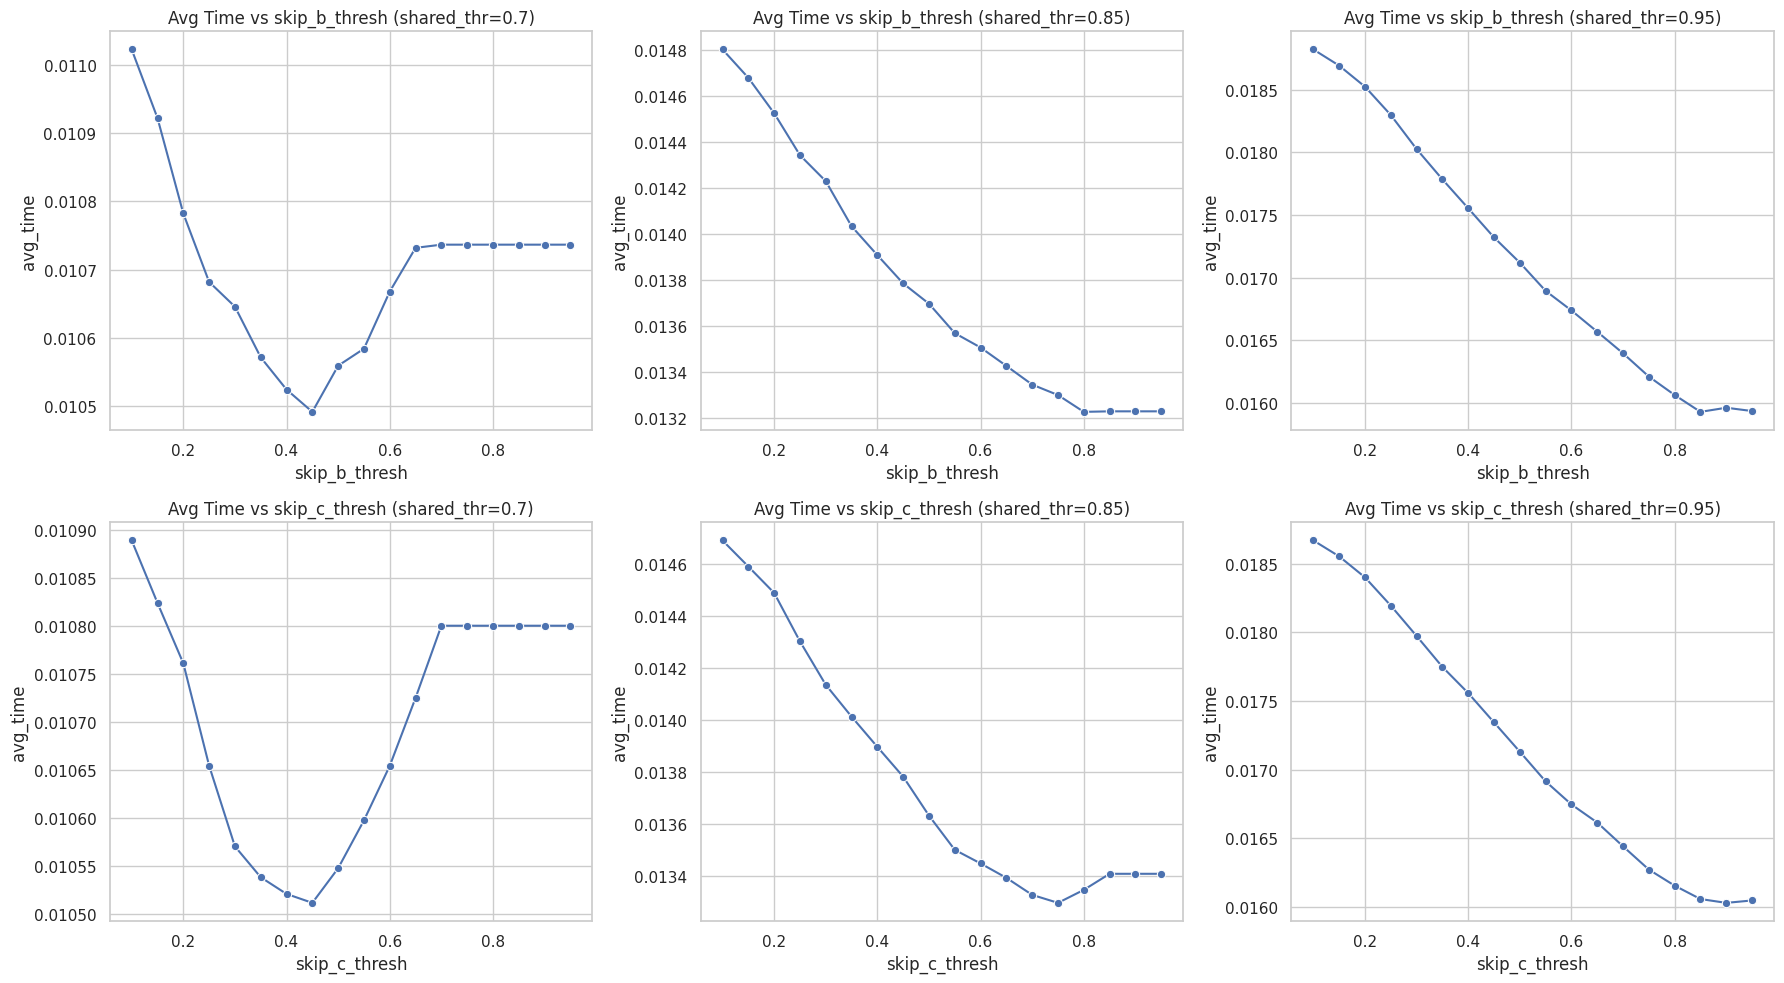

In [15]:
# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure correct column types
df['shared_thr'] = df['shared_thr'].astype(float)

# Select thresholds to plot
conf_levels = [0.70, 0.85, 0.95]

# seaborn theme
sns.set(style="whitegrid")
plt.figure(figsize=(18, 10))

# Plot 1,2,3: skip_b_thresh vs avg_time
for idx, conf in enumerate(conf_levels):
    plt.subplot(2, 3, idx + 1)
    df_conf = df[np.isclose(df['shared_thr'], conf)]
    df_plot = df_conf.groupby('skip_b_thresh')['avg_time'].mean().reset_index()
    sns.lineplot(x='skip_b_thresh', y='avg_time', data=df_plot, marker='o')
    plt.title(f'Avg Time vs skip_b_thresh (shared_thr={conf})')
    plt.xlabel('skip_b_thresh')
    plt.ylabel('avg_time')

# Plot 4,5,6: skip_c_thresh vs avg_time
for idx, conf in enumerate(conf_levels):
    plt.subplot(2, 3, idx + 4)
    df_conf = df[np.isclose(df['shared_thr'], conf)]
    df_plot = df_conf.groupby('skip_c_thresh')['avg_time'].mean().reset_index()
    sns.lineplot(x='skip_c_thresh', y='avg_time', data=df_plot, marker='o')
    plt.title(f'Avg Time vs skip_c_thresh (shared_thr={conf})')
    plt.xlabel('skip_c_thresh')
    plt.ylabel('avg_time')

plt.tight_layout()
plt.show()

In [ ]:
#maybe plotting a graph with both skip_b and skip_c thresholds?

In [16]:
# Save full results to CSV
df.to_csv('gridsearch_same_confidence_with_3_ways_to_skip.csv', index=False)
print("Saved full grid results to 'gridsearch_same_confidence_with_3_ways_to_skip.csv'")

Saved full grid results to 'gridsearch_same_confidence_with_3_ways_to_skip.csv'


In [17]:
# Download CSV to local machine (in Colab)
from google.colab import files
files.download('gridsearch_same_confidence_with_3_ways_to_skip.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>